In [1]:
from cc_search import make_selfplay_checkpoint,make_gullible_checkpoint,make_general_checkpoint,assess_agent_vs_agent,check_output,assess_agent_vs_others
from cc_tools import IteratedPrisonersDilemma, IteratedChicken,IteratedStagHunt, IteratedBoS,PPOTorchPolicy,PPOTrainer,PreferActZero,PreferActOne,DQNTorchPolicy,DQNTrainer,GrimTrigger,GrimTriggerTwo,UncoopExploiterPolicy,RandPolicy,MutalismCoordination, PureCoordination,IteratedAsymBoS,test_matrix,security_vals
from tqdm import tqdm
import pandas as pd
import warnings
import pickle
import json
import numpy as np

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


def compare_initial_trainings(ag_train):
    test_games = [IteratedPrisonersDilemma, IteratedChicken,IteratedStagHunt, IteratedBoS]
    results = {}

    for game_test in tqdm(test_games):
    #ag_train = (PPOTorchPolicy,PPOTrainer)


        checkpoint_self,results_self = make_selfplay_checkpoint(game_test,ag_train,steps = 5)
        
        checkpoint_gull,results_gull = make_gullible_checkpoint(game_test,ag_train,train_repeats=3,steps=5)

        checkpoint_general,results_gen = make_general_checkpoint(game_test,ag_train,train_repeats=3,steps=5)
        

        names = ["self-play only","trained vs cooperators and defectors","trained vs all of it"]

        checkpoints = [checkpoint_self,checkpoint_gull,checkpoint_general]

        """
        print("Self-play trained")
        print(check_output(results_self))
        print("Trained vs pure strats")
        print(check_output(results_gull))
        print("Trained vs general strats")
        print(check_output(results_gen))
        """

        for idx,checkpoint in enumerate(checkpoints):

            results_vs_coop = assess_agent_vs_agent(policies=[ag_train[0],PreferActZero],checkpoints=[checkpoint],environment=IteratedBoS,iters=5)
            results_vs_defect = assess_agent_vs_agent(policies=[ag_train[0],PreferActOne],checkpoints=[checkpoint],environment=IteratedBoS,iters=5)
            
            name_coop = "{} {} results vs coop:".format(game_test.__name__,names[idx])
            
            results[name_coop] = [check_output(results_vs_coop)]
            
            name_defect = "{} {} results vs defect:".format(game_test.__name__,names[idx])
            
            results[name_defect] = [check_output(results_vs_defect)]
        
    return results

ray version: 1.9.2


In [2]:
# functions to test different ways of pretraining agents, currently not used in main experiments

#PPOres = compare_initial_trainings((PPOTorchPolicy,PPOTrainer))
#DQNres = compare_initial_trainings((DQNTorchPolicy,DQNTrainer))

#print(PPOres)
#print(DQNres)

# Generate Results

In [3]:
#the agent policies used and the opponent RL algorithms used

melting_pot_agents = [PreferActOne,PreferActZero,GrimTrigger,GrimTriggerTwo,UncoopExploiterPolicy,RandPolicy]
opponents = [(DQNTorchPolicy,DQNTrainer),(PPOTorchPolicy,PPOTrainer)]

In [4]:
#This is the code that generated pickled results

#results_uncoop, full_uncoop = assess_agent_vs_others((UncoopExploiterPolicy,None),opponents=opponents,strategies=melting_pot_agents,steps=5)
#print(results_uncoop)
#results_PPO, full_PPO = assess_agent_vs_others((PPOTorchPolicy,PPOTrainer),opponents=opponents,strategies=melting_pot_agents,steps=5)
#print(results_PPO)

In [5]:
#necessary to get pickled objects to save, run if that's a problem

def reduce_output(output_dict):
    for game in output_dict.keys():
        game_res = output_dict[game]
        for result in game_res.keys():
            if 'train' in result:
                ex_anal = game_res[result]
                if ex_anal != 'no_train':
                    game_res[result] = (check_output(ex_anal))

# Load Pickled Results

In [6]:
#Load results from PPO and uncooperative agents


# Results for PPO agent trained on self-play
PPO = pickle.load(open("results_PPO.pickle",'rb'))

# Results for uncooperative exploiter agents
UNC = pickle.load(open("results_UNC.pickle",'rb'))

In [7]:
#Test all available games and the functions that generate test agent action steps

games = [IteratedPrisonersDilemma, IteratedChicken,IteratedStagHunt, IteratedBoS, MutalismCoordination, PureCoordination,IteratedAsymBoS]
   
for g in games:
    test_matrix(g)

IteratedPrisonersDilemma
[[-1, -1], [-3, 0]]
[[0, -3], [-2, -2]]

Bully action steps (out of pure and 50/50 strats): (array([0., 1.]), array([0., 1.]))
Maximin action steps (out of pure and 50/50 strats): (array([0., 1.]), array([0., 1.]))
Maximax action steps (out of pure and 50/50 strats): (array([0., 1.]), array([0., 1.]))
Mindless Coop action steps (out of pure and 50/50 strats): (array([1., 0.]), array([1., 0.]))
Security Vals: (-2.0, -2.0)



IteratedChicken
[[0.0, 0.0], [-1.0, 1.0]]
[[1.0, -1.0], [-10.0, -10.0]]

Bully action steps (out of pure and 50/50 strats): (array([0., 1.]), array([0., 1.]))
Maximin action steps (out of pure and 50/50 strats): (array([1., 0.]), array([1., 0.]))
Maximax action steps (out of pure and 50/50 strats): (array([0., 1.]), array([0., 1.]))
Mindless Coop action steps (out of pure and 50/50 strats): (array([0.5, 0.5]), array([0.5, 0.5]))
Security Vals: (-1.0, -1.0)



IteratedStagHunt
[[3, 3], [0, 2]]
[[2, 0], [1, 1]]

Bully action steps (out of pure

In [8]:
#decomposes Row/column average test returns by individual game and opponent type
def fancy_output(dict_name):
    scores = []
    for game_name in dict_name.keys():
        test_outputs = {}
        for act_key in dict_name[game_name].keys():
            if 'train' not in act_key:
                test_outputs[act_key] = [float(np.mean(dict_name[game_name][act_key][0])),float(np.mean(dict_name[game_name][act_key][1]))]
        print()
        game_score = np.mean([v[0] for v in test_outputs.values()])
        scores.append(game_score)
        print(game_name)
        print("Mean test agent return:", game_score)

        print("test agent (row) / opponent (col)")
        print(json.dumps(test_outputs,indent=3))
    return scores

#returns average welfare by game averaged over all opponents
def welfare(dict_name):
    scores = []
    for game_name in dict_name.keys():
        test_outputs = {}
        for act_key in dict_name[game_name].keys():
            if 'train' not in act_key:
                test_outputs[act_key] = [float(np.mean(dict_name[game_name][act_key][0])),float(np.mean(dict_name[game_name][act_key][1]))]
        game_score = np.mean([v[0]+v[1] for v in test_outputs.values()])
        scores.append(game_score)
    return scores

# Results Breakdown by test scenario/matrix game

In [9]:
scoresPPO = fancy_output(PPO)


IteratedPrisonersDilemma
Mean test agent return: -13.866750000000001
test agent (row) / opponent (col)
{
   "PreferActOne": [
      0.0,
      -30.0
   ],
   "PreferActZero": [
      -0.932,
      -29.534000000000002
   ],
   "GrimTrigger": [
      -20.0,
      -20.0
   ],
   "GrimTriggerTwo": [
      -20.0,
      -20.0
   ],
   "UncoopExploiterPolicy": [
      -20.0,
      -20.0
   ],
   "RandPolicy": [
      -10.002,
      -24.999
   ],
   "DQNTorchPolicy": [
      -20.0,
      -20.0
   ],
   "PPOTorchPolicy": [
      -20.0,
      -20.0
   ]
}

IteratedChicken
Mean test agent return: -5.0573125
test agent (row) / opponent (col)
{
   "PreferActOne": [
      -5.0,
      5.0
   ],
   "PreferActZero": [
      -0.466,
      0.466
   ],
   "GrimTrigger": [
      -10.0,
      10.0
   ],
   "GrimTriggerTwo": [
      -10.0,
      10.0
   ],
   "UncoopExploiterPolicy": [
      -10.0,
      10.0
   ],
   "RandPolicy": [
      -4.992500000000001,
      4.992500000000001
   ],
   "DQNTorchPolicy

In [10]:
scoresUNC = fancy_output(UNC)


IteratedPrisonersDilemma
Mean test agent return: -14.995375
test agent (row) / opponent (col)
{
   "PreferActOne": [
      -18.994999999999997,
      -20.502499999999998
   ],
   "PreferActZero": [
      -1.001,
      -29.4995
   ],
   "GrimTrigger": [
      -20.0,
      -20.0
   ],
   "GrimTriggerTwo": [
      -20.0,
      -20.0
   ],
   "UncoopExploiterPolicy": [
      -20.0,
      -20.0
   ],
   "RandPolicy": [
      -9.966999999999999,
      -25.0165
   ],
   "DQNTorchPolicy": [
      -10.0,
      -25.0
   ],
   "PPOTorchPolicy": [
      -20.0,
      -20.0
   ]
}

IteratedChicken
Mean test agent return: -2.3207500000000003
test agent (row) / opponent (col)
{
   "PreferActOne": [
      -10.996500000000001,
      7.636500000000001
   ],
   "PreferActZero": [
      4.4945,
      -14.504499999999998
   ],
   "GrimTrigger": [
      9.9905,
      -10.000499999999999
   ],
   "GrimTriggerTwo": [
      9.9905,
      -10.000499999999999
   ],
   "UncoopExploiterPolicy": [
      -20.0,
    

In [11]:
import matplotlib.pyplot as plt

# Plot Test agent returns averaged over opponent types

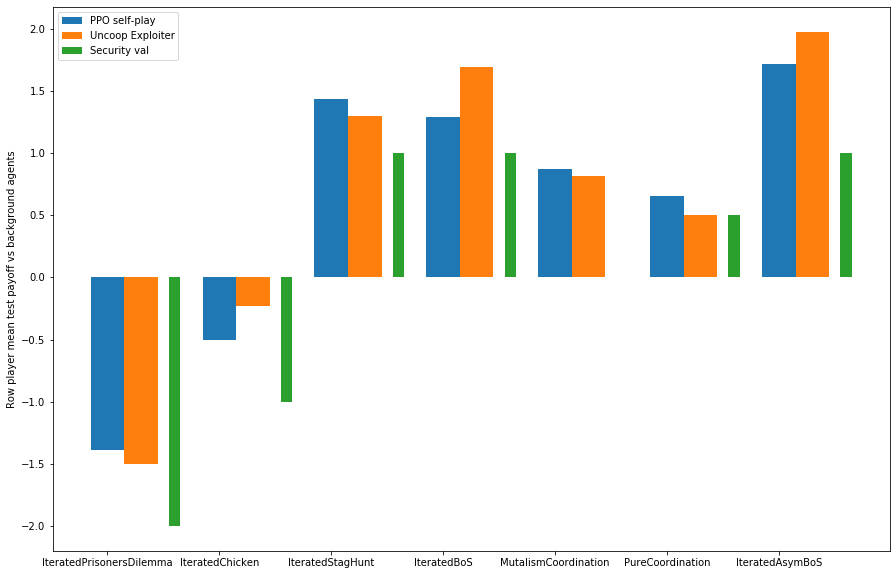

In [12]:
plt.figure(figsize=(15,10))
plt.bar(range(len(scoresPPO)),np.array(scoresPPO)/10,width=0.3,label = 'PPO self-play')
plt.bar(np.arange(len(scoresPPO))+0.3,np.array(scoresUNC)/10,width=0.3,label='Uncoop Exploiter')
plt.bar(np.arange(len(scoresPPO))+0.6,[security_vals(g)[0] for g in games],width=0.1,label='Security val')
plt.legend()
plt.xticks(range(len(scoresPPO)),labels=[g.__name__ for g in games])
plt.ylabel("Row player mean test payoff vs background agents")
plt.show()

# Plot Test agent welfare averaged over opponent types

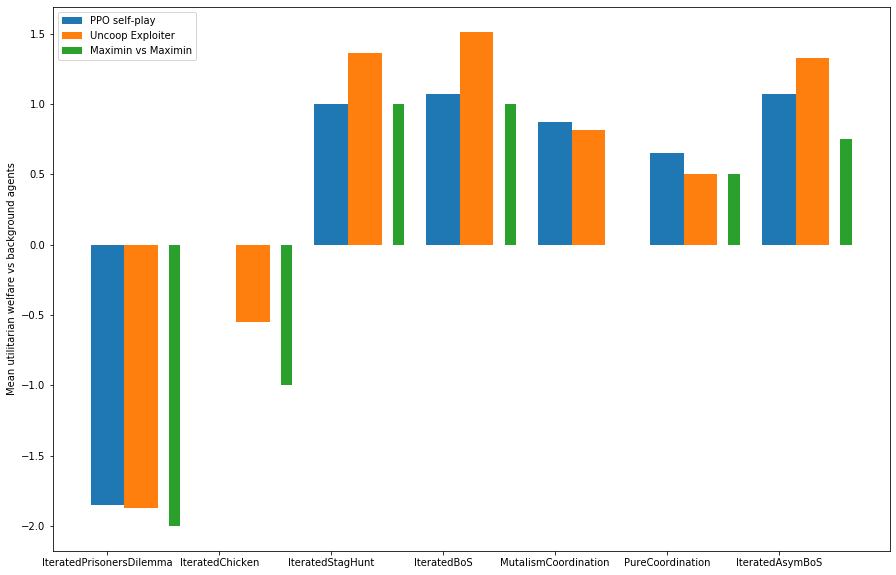

In [13]:
plt.figure(figsize=(15,10))
plt.bar(range(len(scoresPPO)),np.array(welfare(PPO))/20,width=0.3,label = 'PPO self-play')
plt.bar(np.arange(len(scoresPPO))+0.3,np.array(welfare(UNC))/20,width=0.3,label='Uncoop Exploiter')
plt.bar(np.arange(len(scoresPPO))+0.6,[np.sum(security_vals(g))/2 for g in games],width=0.1,label='Maximin vs Maximin')
plt.legend()
plt.xticks(range(len(scoresPPO)),labels=[g.__name__ for g in games])
plt.ylabel("Mean utilitarian welfare vs background agents")
plt.show()

# Overall Results

In [14]:
 final_results = {"PPO return": np.mean(np.array(scoresPPO)/10),
 "Uncoop return": np.mean(np.array(scoresUNC)/10),
 "PPO welfare": np.mean(np.array(welfare(PPO))/10),
 "Uncoop welfare": np.mean(np.array(welfare(UNC))/10),
 "PPO normalized return": np.mean(np.array(scoresPPO)/10 - np.array(scoresUNC)/10),
 "PPO normalized welfare": np.mean(np.array(welfare(PPO))/10 - np.array(welfare(UNC))/10)
 }

print("return averaged vs {}".format([x for x in list(PPO['IteratedPrisonersDilemma'].keys()) if 'train' not in x]))
pd.DataFrame({"PPO return": np.array(scoresPPO)/10,
 "Uncoop return": np.array(scoresUNC)/10,
 "PPO welfare": np.array(welfare(PPO))/10,
 "Uncoop welfare": np.array(welfare(UNC))/10,
 "PPO normalized return": np.array(scoresPPO)/10 - np.array(scoresUNC)/10,
 "PPO normalized welfare": np.array(welfare(PPO))/10 - np.array(welfare(UNC))/10
 },index = [g.__name__ for g in games])

return averaged vs ['PreferActOne', 'PreferActZero', 'GrimTrigger', 'GrimTriggerTwo', 'UncoopExploiterPolicy', 'RandPolicy', 'DQNTorchPolicy', 'PPOTorchPolicy']


,PPO return,Uncoop return,PPO welfare,Uncoop welfare,PPO normalized return,PPO normalized welfare
IteratedPrisonersDilemma,-1.386675,-1.499537,-3.693337,-3.749769,0.112862,0.056431
IteratedChicken,-0.505731,-0.232075,0.000000,-1.105250,-0.273656,1.105250
IteratedStagHunt,1.432187,1.299925,2.000000,2.724675,0.132262,-0.724675
IteratedBoS,1.289700,1.692881,2.149500,3.025125,-0.403181,-0.875625
MutalismCoordination,0.869106,0.811881,1.738213,1.623763,0.057225,0.114450
PureCoordination,0.654537,0.500613,1.309075,1.001225,0.153925,0.307850
IteratedAsymBoS,1.715275,1.973463,2.144094,2.650100,-0.258188,-0.506006


In [15]:
final_results

{'PPO return': 0.5811999999999999,
 'Uncoop return': 0.6495928571428572,
 'PPO welfare': 0.8067919642857143,
 'Uncoop welfare': 0.8814098214285716,
 'PPO normalized return': -0.06839285714285723,
 'PPO normalized welfare': -0.07461785714285722}